## Ground truth curvature

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

## Hemisphere

In [2]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

def ellipsoid_ground_truth(point_cloud, a, b, c):
    #point_cloud: N by 3 array
    cur = []
    for p in point_cloud:
        k = 1 / (a **2 * b**2 * c**2 * (p[0]**2 / a**4 + p[1]**2 / b**4 + p[2]**2 / c**4) **2)
        cur.append(k)
    return cur
        

In [13]:
def hemisphere(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(v)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

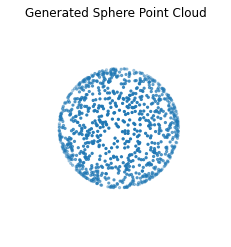

In [107]:
hemi = hemisphere(1, 1, 1, num_points = 1000)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hemi[:, 0], hemi[:, 1], hemi[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 0)
plt.axis('off')
plt.show()

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(hemi)

In [19]:
Y = pca.transform(hemi)

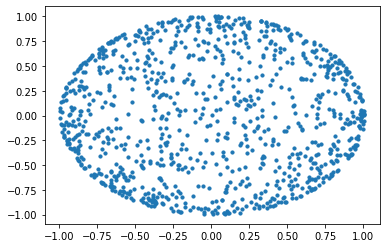

In [24]:
plt.scatter(Y[:, 0], Y[:, 1], s = 10)
plt.show()

## saddle

In [25]:
import sympy as sym

In [27]:
def rejection_sample_formula(f, variables):
    G = sym.Matrix.zeros(2,2)
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sym.diff(f, x1).T  * sym.diff(f, x2))[0]
    return sym.sqrt(G.det().simplify()).simplify()

In [28]:
a = sym.Symbol('a')
b = sym.Symbol('b')
x = sym.Symbol("x")
y = sym.Symbol("y")
f = sym.Matrix(
    [x,y,a*x**2 + b*y**2]
)

variables = [x, y]
rej = rejection_sample_formula(f, variables)
rej

sqrt(4*a**2*x**2 + 4*b**2*y**2 + 1)

In [100]:
#| export
def rejection_sample_for_saddle(n,a,b):
    x = np.random.random(n)*2 - 1 # random values in -1, 1
    y = np.random.random(n)*2 - 1
    fx = np.sqrt(4*a**2*x**2 + 4*b**2*y**2 + 1)
    yvec = np.random.random(n) * (1/np.max(fx))
    return x[yvec < fx], y[yvec < fx]

def paraboloid(n=2000,a=1,b=-1, seed=None, use_guide_points = False):
    """Sample roughly n points on a saddle, using rejection sampling for even density coverage
    Defined by $ax^2 + by^2$. 

    Parameters
    ----------
    n : int, optional
        number of points, by default 2000
    a : int, optional
        ellipsoid param1, by default 1
    b : int, optional
        ellipsoid param2, by default -1
    seed : int, optional
        For repeatability, seed the randomness, by default None

    Returns
    -------
    The sampled points, and the curvatures of each point
    """
    if use_guide_points:
        n = n - 1
    np.random.seed(seed)
    x, y = rejection_sample_for_saddle(n,a,b)
    if use_guide_points:
        x = np.concatenate([[0],x])
        y = np.concatenate([[0],y])
    data = np.zeros((len(x), 3))
    data[:, 0] = x
    data[:, 1] = y
    data[:, 2] = a*x**2 + b*y**2
    # compute curvature of sampled saddle region
    # TODO: Compute gaussian curvature
    # TODO: Currently assuming that b is negative (hyperbolic paraboloid)
    ap = np.sqrt(1/a) 
    bp = b/np.abs(b) * np.sqrt(1/np.abs(b))
    ks = -(4*a**6 * b**6)/(a**4*b**4 + 4*b**4*x**2+4*a**4*y**2)**2
    
    return data, ks


def plot_3d(X,distribution=None, title="",lim=None,use_plotly=False, zlim = None, colorbar = False, cmap="plasma"):
    if distribution is None:
        distribution = np.zeros(len(X))
    if lim is None:
        lim = np.max(np.linalg.norm(X,axis=1))
    if zlim is None:
        zlim = lim
    if use_plotly:
        d = {'x':X[:,0],'y':X[:,1],'z':X[:,2],'colors':distribution}
        df = pd.DataFrame(data=d)
        fig = px.scatter_3d(df, x='x',y='y',z='z',color='colors', title=title, range_x=[-lim,lim], range_y=[-lim,lim],range_z=[-zlim,zlim])
        fig.show()
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        ax.axes.set_xlim3d(left=-lim, right=lim)
        ax.axes.set_ylim3d(bottom=-lim, top=lim)
        ax.axes.set_zlim3d(bottom=-zlim, top=zlim)
        im = ax.scatter(X[:,0],X[:,1],X[:,2],c=distribution,cmap=cmap)
        ax.set_title(title)
        ax.view_init(90,0)
        if colorbar: fig.colorbar(im, ax=ax)
        plt.show()

In [105]:
saddle, ks = paraboloid(n=1000, a = 1, b = -1,use_guide_points=True)

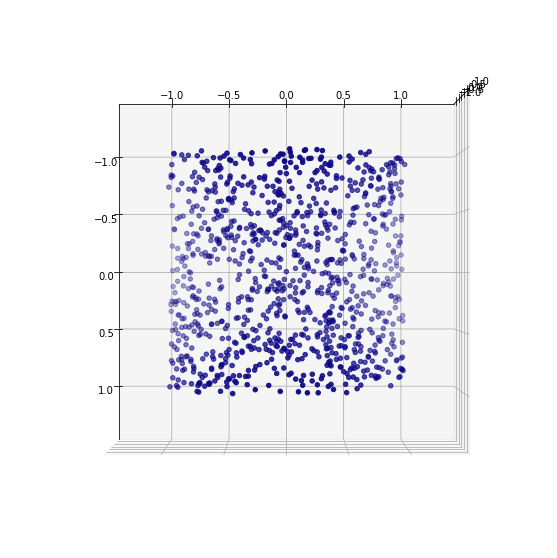

In [106]:
plot_3d(saddle)

In [54]:
pca = PCA(n_components=2).fit(saddle)
Y = pca.transform(saddle)

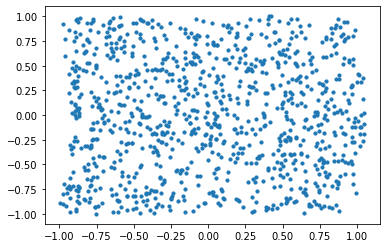

In [55]:
plt.scatter(Y[:, 0], Y[:, 1], s = 10)
plt.show()